---
title: stata教程15-回归变动的检验
date: 2019-01-11 17:17:55
tags: [stata]
toc: true
mathjax: true

---


<span></span>
<!-- more -->

如果一根直线解决不了问题, 我们就用两根直线。

<img src="images/jingjibiandong.png"/>

很多时候, 经济规律会随着时间的推移在某个时间点发生变化, 这个时间点就叫做断点, 就如上图所示的样子。为了检验断点是否存在, 我们可以使用下面的方法:

(如上图所示)

- 先做(-0.5, 0.5)之间的样本的回归
- 再做(-0.5, 0)之间的样本的回归
- 最后做(0, 0.5)之间的样本的回归

利用三个回归的残差平方和根据公式计算F统计量, 利用F分布来给出显著性检验, 如果F显著, 则拒绝原假设(不存在断点), 否则认为不存在断点。

F(K, n-2K):

$$
F = {{(ssr - ssr1 - ssr2)/K} \over {(ssr1 + ssr2)/(n - 2K)}}
$$

其中:

- ssr: 所有样本的回归方程的残差平方和
- ssr1: 断点之前的样本的回归方程的残差平方和
- ssr2: 断点之后的样本的回归方程的残差平方和
- n: 样本量
- K: 解释变量(自变量)的个数, 包含截距项

下面以陈强教授书中的案例演示一下:

数据是中国1978-2006年人均消费和人均GDP数据, 下面加载数据, 然后看一下数据的基本情况:

In [1]:
use data/consumption_china.dta, clear

In [2]:
sum 


    Variable |        Obs        Mean    Std. Dev.       Min        Max
-------------+---------------------------------------------------------
        year |         29        1992    8.514693       1978       2006
           c |         29    2005.897    1828.339        184       6138
           y |         29     4569.31    4571.836        381      16165


数据中变量的解释:

- year: 年份
- c: 居民人均消费
- y: 居民人均GDP

绘制两个变量的时间趋势图, 我们的目的是想要检测一下在1992年是否存在经济的变动点:

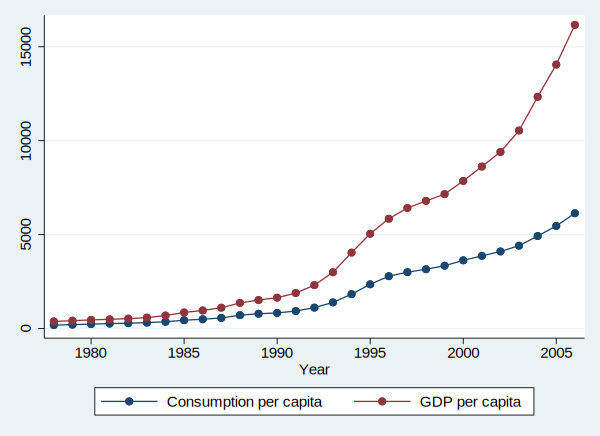

In [3]:
graph twoway connect c y year

### 第一步, 所有样本构建回归方程

使用人均GDP预测人均消费:

In [4]:
reg c y


      Source |       SS           df       MS      Number of obs   =        29
-------------+----------------------------------   F(1, 27)        =   2441.51
       Model |  92575330.6         1  92575330.6   Prob > F        =    0.0000
    Residual |   1023766.1        27  37917.2631   R-squared       =    0.9891
-------------+----------------------------------   Adj R-squared   =    0.9887
       Total |  93599096.7        28  3342824.88   Root MSE        =    194.72

------------------------------------------------------------------------------
           c |      Coef.   Std. Err.      t    P>|t|     [95% Conf. Interval]
-------------+----------------------------------------------------------------
           y |   .3977205   .0080491    49.41   0.000     .3812051     .414236
       _cons |    188.588   51.57697     3.66   0.001     82.76078    294.4152
------------------------------------------------------------------------------


计算残差平方和:

In [5]:
scalar ssr=e(rss)

In [6]:
dis ssr

1023766.1


### 第二步, 构建1992年之前的样本的回归模型

In [7]:
reg c y if year < 1992


      Source |       SS           df       MS      Number of obs   =        14
-------------+----------------------------------   F(1, 12)        =   4381.66
       Model |  829144.945         1  829144.945   Prob > F        =    0.0000
    Residual |   2270.7688        12  189.230733   R-squared       =    0.9973
-------------+----------------------------------   Adj R-squared   =    0.9970
       Total |  831415.714        13  63955.0549   Root MSE        =    13.756

------------------------------------------------------------------------------
           c |      Coef.   Std. Err.      t    P>|t|     [95% Conf. Interval]
-------------+----------------------------------------------------------------
           y |   .4995544   .0075468    66.19   0.000     .4831113    .5159975
       _cons |   12.98254    7.87353     1.65   0.125    -4.172404    30.13749
------------------------------------------------------------------------------


计算该方程的残差平方和:

In [8]:
scalar ssr1 = e(rss)

In [9]:
dis ssr1

2270.7688


### 第三步, 构建1992年之后的样本的回归模型

In [10]:
reg c y if year >= 1992


      Source |       SS           df       MS      Number of obs   =        15
-------------+----------------------------------   F(1, 13)        =    764.58
       Model |  28749474.3         1  28749474.3   Prob > F        =    0.0000
    Residual |  488822.141        13  37601.7031   R-squared       =    0.9833
-------------+----------------------------------   Adj R-squared   =    0.9820
       Total |  29238296.4        14  2088449.74   Root MSE        =    193.91

------------------------------------------------------------------------------
           c |      Coef.   Std. Err.      t    P>|t|     [95% Conf. Interval]
-------------+----------------------------------------------------------------
           y |    .359886   .0130153    27.65   0.000     .3317682    .3880038
       _cons |   566.4531   115.2172     4.92   0.000     317.5415    815.3646
------------------------------------------------------------------------------


计算该方程的残差平方和:

In [11]:
scalar ssr2 = e(rss)

In [12]:
dis ssr2

488822.14


### 第四步, 计算F统计量

根据上面的公式, 我们可以计算F统计量:

In [15]:
scalar F = ((ssr-ssr1-ssr2)/2)/((ssr1+ssr2) / 25)

In [16]:
dis F

13.558361


得到F统计量, 我们查找F分布表就能知道假设是否成立了。


### 另外一种方法

上面的方法有些繁琐, 我们还可以使用构建虚拟变量的方法, 思路是这样的:

- 构建虚拟变量d, 标志数据是否来自1992年之后, 是则取1, 否则取0
- 计算d和自变量y的交互项: yd
- 构建回归方程, reg c y d yd

下面我们来快速做一下:

生成虚拟变量d:

In [17]:
gen d = (year > 1991)

生成交互项变量:

In [18]:
gen yd = y*d

回归分析:

In [19]:
reg c y d yd


      Source |       SS           df       MS      Number of obs   =        29
-------------+----------------------------------   F(3, 25)        =   1579.95
       Model |  93108003.8         3  31036001.3   Prob > F        =    0.0000
    Residual |   491092.91        25  19643.7164   R-squared       =    0.9948
-------------+----------------------------------   Adj R-squared   =    0.9941
       Total |  93599096.7        28  3342824.88   Root MSE        =    140.16

------------------------------------------------------------------------------
           c |      Coef.   Std. Err.      t    P>|t|     [95% Conf. Interval]
-------------+----------------------------------------------------------------
           y |   .4995544   .0768917     6.50   0.000      .341193    .6579158
           d |   553.4705   115.6304     4.79   0.000     315.3252    791.6159
          yd |  -.1396684    .077465    -1.80   0.083    -.2992106    .0198738
       _cons |   12.98254   80.22052     0.16   0.

最后计算d与yd的联合显著性:

In [20]:
test d yd


 ( 1)  d = 0
 ( 2)  yd = 0

       F(  2,    25) =   13.56
            Prob > F =    0.0001


上面计算得到的F统计量和第一种方法计算得到的F是相同的。

如果你怀疑在1992年前后的样本扰动项是异方差的, 那么我们可以进行异方差稳健的回归分析:

In [21]:
reg c y d yd, r


Linear regression                               Number of obs     =         29
                                                F(3, 25)          =    2290.56
                                                Prob > F          =     0.0000
                                                R-squared         =     0.9948
                                                Root MSE          =     140.16

------------------------------------------------------------------------------
             |               Robust
           c |      Coef.   Std. Err.      t    P>|t|     [95% Conf. Interval]
-------------+----------------------------------------------------------------
           y |   .4995544   .0104615    47.75   0.000     .4780085    .5211003
           d |   553.4705   138.6738     3.99   0.001     267.8665    839.0746
          yd |  -.1396684   .0186167    -7.50   0.000    -.1780103   -.1013265
       _cons |   12.98254   8.966059     1.45   0.160    -5.483399    31.44849
--------------

然后进行d和yd的联合显著性检验:

In [22]:
test d yd


 ( 1)  d = 0
 ( 2)  yd = 0

       F(  2,    25) =   34.01
            Prob > F =    0.0000


虽然F值不同, 但是最终的结论是一样的。

### 参考文献

陈强[高级计量经济学]